# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [194]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [195]:
# Use this space for any additional import statements you need

from collections import Counter

In [196]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens)) / len(tokens)
    num_characters = sum([len(i) for i in tokens]) 
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        token_counts = Counter(tokens).most_common(5)
        for token, count in token_counts:
            print(f"{token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    ret = []
    for token in tokens:
        if token.lower() not in sw:
            ret.append(token)
    return ret
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return whitespace_pattern.split(text.strip())

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [197]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "" # change to your location if it is not in the same directory as your notebook
twitter_folder = "/Users/sahilwadhwa/M1 Results/twitter/"
lyrics_folder = "/Users/sahilwadhwa/M1 Results/lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [198]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [199]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [200]:
# read in the lyrics here

lyrics_data = {}

for artist in os.listdir(lyrics_folder):
    join = os.path.join(lyrics_folder, artist)
    
    if os.path.isdir(join):
        lyrics_data[artist] = {}  
        for file in os.listdir(join):
            path = os.path.join(join, file)
            if os.path.isfile(path):
                with open(path, 'r', encoding='utf-8') as file:
                    read = file.read()
                    title = os.path.splitext(path)[0]  
                    lyrics_data[artist][title] = read

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [201]:
#Flatten lyrics_data before tokenization

lyrics_data_updated = []
for artist, songs in lyrics_data.items():
    for path, lyrics in songs.items():
        song = os.path.splitext(os.path.basename(path))[0]
        lyrics_data_updated.append({
            "artist": artist,
            "song": song,
            "lyrics": lyrics })

lyrics_data_updated = pd.DataFrame(lyrics_data_updated)
lyrics_data_updated['song'] = lyrics_data_updated['song'].str.replace('cher_', '', regex=False)
lyrics_data_updated['song'] = lyrics_data_updated['song'].str.replace('robyn_', '', regex=False)

In [202]:
lyrics_data_updated

,artist,song,lyrics
0,robyn,includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."
...,...,...,...
415,cher,takeitfromtheboys,"""Take It From The Boys""\n\n\n\nSo scared I nev..."
416,cher,dreambaby,"""Dream Baby""\n\n\n\nI found the boy for me\nHe..."
417,cher,pleasedonttellme,"""Please Don't Tell Me""\n\n\n\nYa shook the ove..."
418,cher,ihopeyoufindit,"""I Hope You Find It""\n\n\n\nThese clouds aren'..."


In [203]:
print(lyrics_data_updated["artist"].value_counts())


artist
cher     316
robyn    104
Name: count, dtype: int64


In [204]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data_updated["tokens"] = lyrics_data_updated["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data_updated["num_tokens"] = lyrics_data_updated["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [205]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [206]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1128442,cher,John & Deb 💋💋,"[john, deb, 💋💋]"
1103101,cher,"🇺🇦🌻 Creative, Mom, Wife, Cali, Fighting for my...","[🇺🇦🌻, creative, mom, wife, cali, fighting, dau..."
343942,robyn,"👭🌈 Feminist, queer femme, fat. Gérante de @la_...","[👭🌈, feminist, queer, femme, fat, gérante, de,..."
2153812,cher,"15 years,Croatia ❤Justin❤","[15, yearscroatia, ❤justin❤]"
2535763,cher,❤'so fashion n beauty ✌,"[❤so, fashion, n, beauty, ✌]"
1815676,cher,Take a deep breath and enjoy your life Atheist...,"[take, deep, breath, enjoy, life, atheist, gay..."
1236642,cher,"Wife, mom of 3, Realtor, Educator and compulsi...","[wife, mom, 3, realtor, educator, compulsive, ..."
1045905,cher,"without the dark, we'd never see the stars ✨ 🌟...","[without, dark, wed, never, see, stars, ✨, 🌟, ..."
1293836,cher,"Irish mother to the world. I will hug you, cal...","[irish, mother, world, hug, call, make, soda, ..."
3035714,cher,ISU❤️💛 El Ed 🍎,"[isu❤️💛, el, ed, 🍎]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement of my tokenization that I could theoretically carry out is the handling of emojis

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [207]:
# your code here

#Cher Lyrics
tokens_c = lyrics_data_updated[lyrics_data_updated["artist"] == "cher"]["tokens"].explode().tolist()
print("Descriptive Stats for Cher Lyrics:")
descriptive_stats(tokens_c, num_tokens = 5)

#Robyn Lyrics
tokens_r = lyrics_data_updated[lyrics_data_updated["artist"] == "robyn"]["tokens"].explode().tolist()
print("\nDescriptive Stats for Robyn Lyrics:")
descriptive_stats(tokens_r, num_tokens = 5)

Descriptive Stats for Cher Lyrics:
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.
love: 1004
im: 513
know: 486
dont: 440
youre: 333

Descriptive Stats for Robyn Lyrics:
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.
know: 308
dont: 301
im: 299
love: 275
got: 251


[15227, 2156, 0.14159059565245943, 73787]

Q: what observations do you make about these data? 

A: The observations that I made about these data is that there are more tokens/unique tokens in the cher lyrics but that is mainly because the # of characters is also greater in the cher lyrics. The lexical diversity is actually higher in the robyn lyrics.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [208]:
# your code here

tokens_c_tw = twitter_data[twitter_data["artist"] == "cher"]["tokens"].explode().tolist()
tokens_r_tw = twitter_data[twitter_data["artist"] == "robyn"]["tokens"].explode().tolist()

n_cutoff = 5
cher_counter = Counter(tokens_c)
robyn_counter = Counter(tokens_r)
cher_counter_tw = Counter(tokens_c_tw)
robyn_counter_tw = Counter(tokens_r_tw)

common_tokens = set()
for token in cher_counter:
    if cher_counter[token] >= n_cutoff and robyn_counter[token] >= n_cutoff:
        common_tokens.add(token)
    
common_tokens_tw = set()
for token in cher_counter_tw:
    if cher_counter_tw[token] >= n_cutoff and robyn_counter_tw[token] >= n_cutoff:
        common_tokens_tw.add(token)
        
cher_ratios = []
robyn_ratios = []
for token in common_tokens:
    cher_concentration = cher_counter[token] / len(tokens_c)
    robyn_concentration = robyn_counter[token] / len(tokens_r)
    
    cher_ratio = cher_concentration / robyn_concentration
    robyn_ratio = robyn_concentration / cher_concentration
    
    cher_ratios.append((token, cher_ratio))
    robyn_ratios.append((token, robyn_ratio))
    
cher_ratios_tw = []
robyn_ratios_tw = []
for token in common_tokens_tw:
    cher_concentration_tw = cher_counter_tw[token] / len(tokens_c_tw)
    robyn_concentration_tw = robyn_counter_tw[token] / len(tokens_r_tw)
    
    cher_ratio_tw = cher_concentration_tw / robyn_concentration_tw
    robyn_ratio_tw = robyn_concentration_tw / cher_concentration_tw
    
    cher_ratios_tw.append((token, cher_ratio_tw))
    robyn_ratios_tw.append((token, robyn_ratio_tw))
    
top_cher_10 = sorted(cher_ratios, key=lambda x: x[1], reverse=True)[:10]
top_robyn_10 = sorted(robyn_ratios, key=lambda x: x[1], reverse=True)[:10]
top_cher_tw_10 = sorted(cher_ratios_tw, key=lambda x: x[1], reverse=True)[:10]
top_robyn_tw_10 = sorted(robyn_ratios_tw, key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Cher Lyrics Tokens:")
for token, ratio in top_cher_10:
    print(f"  {token}: {ratio:.3f}")

print("\nTop 10 Robyn Lyrics Tokens:")
for token, ratio in top_robyn_10:
    print(f"  {token}: {ratio:.3f}")

print("\nTop 10 Cher Twitter Tokens:")
for token, ratio in top_cher_tw_10:
    print(f"  {token}: {ratio:.3f}")

print("\nTop 10 Robyn Twitter Tokens:")
for token, ratio in top_robyn_tw_10:
    print(f"  {token}: {ratio:.3f}")

Top 10 Cher Lyrics Tokens:
  walk: 10.005
  find: 9.680
  enough: 7.813
  man: 7.525
  without: 7.462
  strong: 6.529
  live: 5.766
  believe: 5.589
  tears: 4.833
  name: 4.409

Top 10 Robyn Lyrics Tokens:
  beat: 20.257
  dance: 14.152
  work: 11.951
  hang: 11.204
  forgive: 7.548
  shake: 7.076
  alright: 7.076
  party: 6.192
  space: 5.897
  pretend: 5.897

Top 10 Cher Twitter Tokens:
  grandmother: 35.353
  #fbr: 24.574
  resister: 24.447
  #resister: 24.036
  nana: 23.663
  rbsoul: 20.586
  grandma: 19.901
  #theresistance: 18.901
  hiphoprap: 17.960
  gop: 17.330

Top 10 Robyn Twitter Tokens:
  vänner: 293.046
  bäst: 210.229
  sveriges: 208.105
  träning: 203.504
  brinner: 198.701
  följ: 195.541
  gärna: 194.978
  arbetar: 187.256
  varje: 184.039
  familj: 180.500


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The main observations I have are that there are different themes in each set of 10 tokens. For example, the top 10 Robyn twitter tokens have a Swedish theme while the top 10 Cher Twitter tokens have a old theme.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [209]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

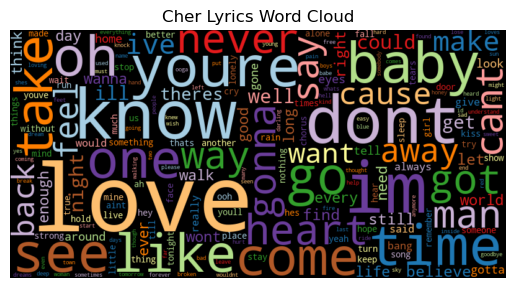

In [210]:
#Cher Lyrics Word Cloud
cher_freq = count_words(lyrics_data_updated[lyrics_data_updated["artist"] == "cher"], min_freq=5)
wordcloud(cher_freq['freq'], title = "Cher Lyrics Word Cloud", stopwords = set(sw))

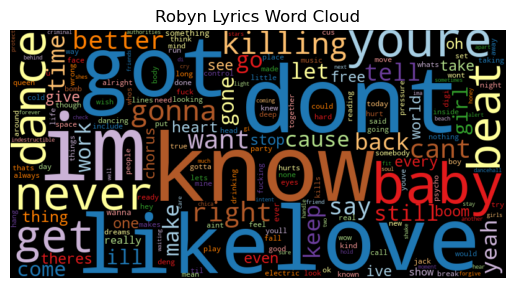

In [211]:
#Robyn Lyrics Word Cloud
cher_freq = count_words(lyrics_data_updated[lyrics_data_updated["artist"] == "robyn"], min_freq=5)
wordcloud(cher_freq['freq'], title = "Robyn Lyrics Word Cloud", stopwords = set(sw))

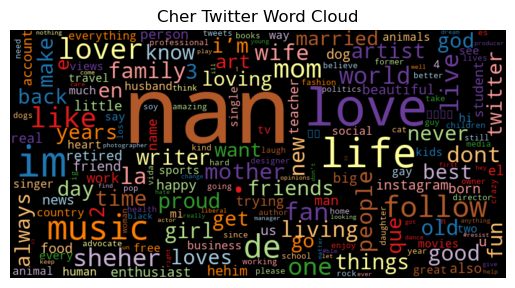

In [212]:
#Cher Twitter Word Cloud
cher_freq_tw = count_words(twitter_data[twitter_data["artist"] == "cher"], min_freq=5)
wordcloud(cher_freq_tw['freq'], title = "Cher Twitter Word Cloud", stopwords = set(sw))

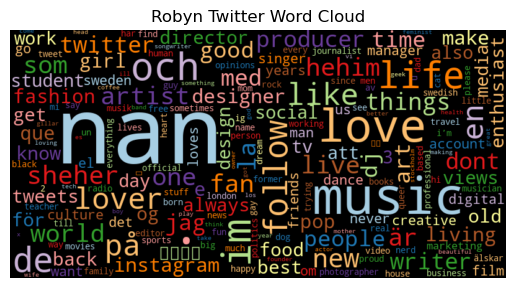

In [213]:
#Robyn Twitter Word Cloud
robyn_freq_tw = count_words(twitter_data[twitter_data["artist"] == "robyn"], min_freq=5)
wordcloud(robyn_freq_tw['freq'], title = "Robyn Twitter Word Cloud", stopwords = set(sw))

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The main observation I have is that the lyrics wordclouds are similar as are the Twitter wordclouds